##### **Code for determing the transition points betwen phases P1 and P2 for every ant in the experiment.**
##### This script requires the files 'timedata_C*.csv', PositionData_C*.csv' and 'stats_corrected.csv' resulting from Code_1, Code_2, and manual correction of 'larva_detect_frame' if required.

##### *Note: any missing values in the input files will cause this script to error. However, in Code_1, missing values are reliably replaced in 'timedata_C\*\.csv' files, so all* *subsequent steps should run without error.*

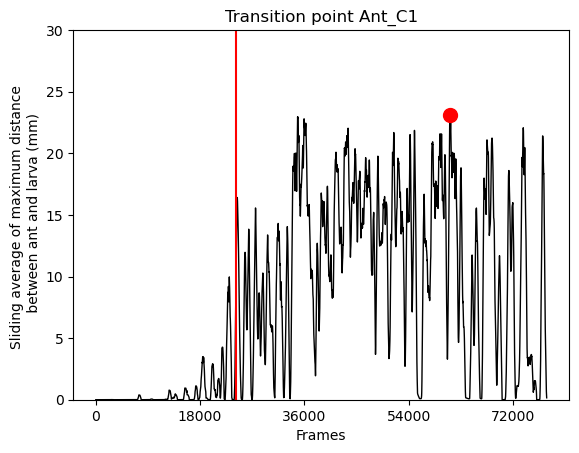

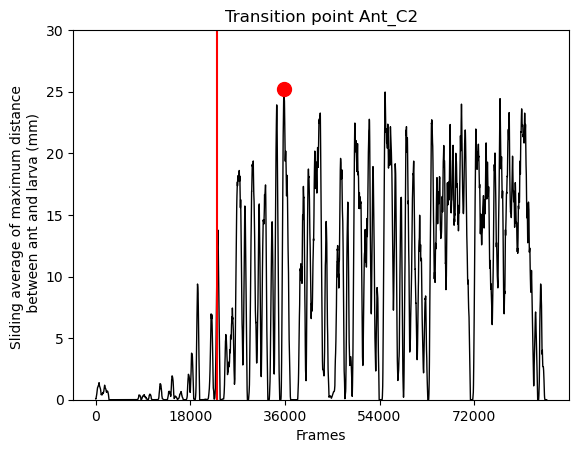

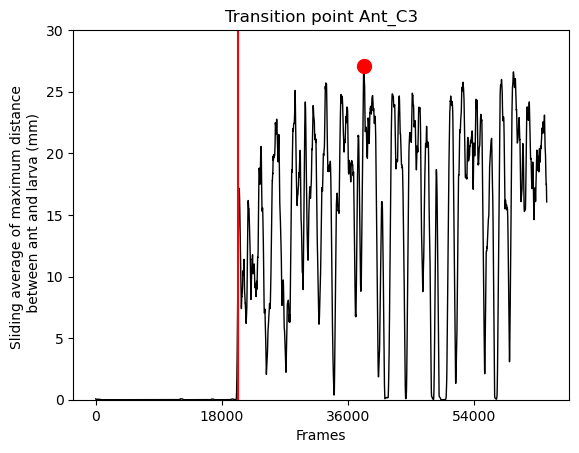

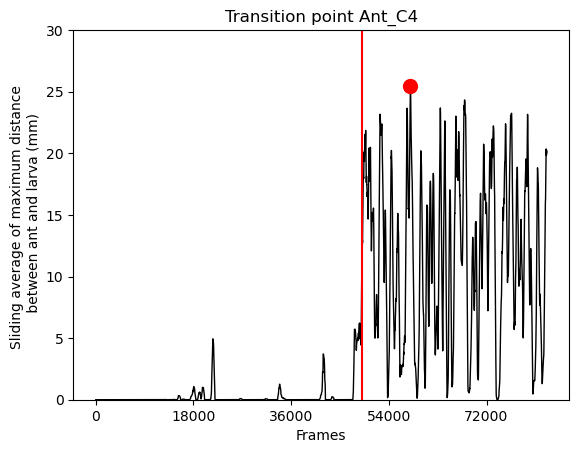

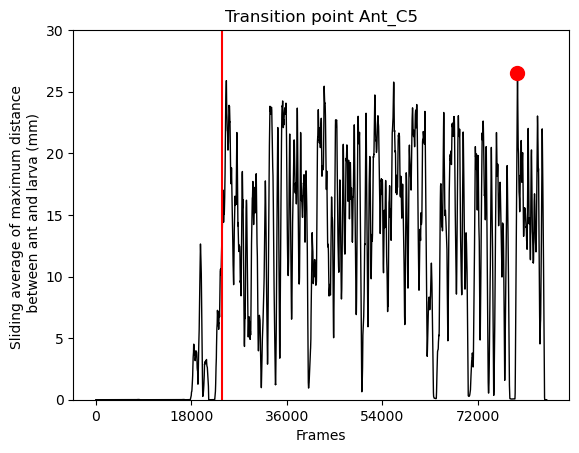

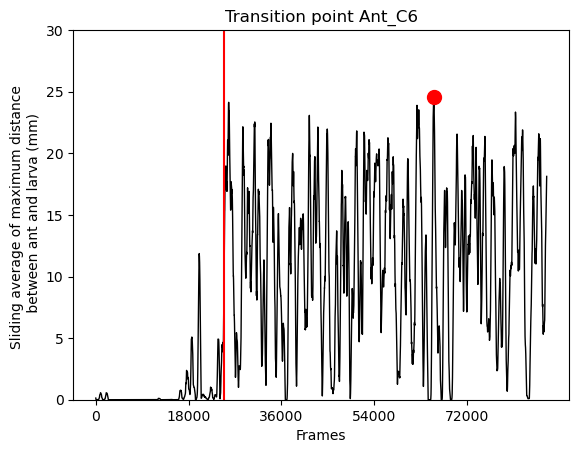

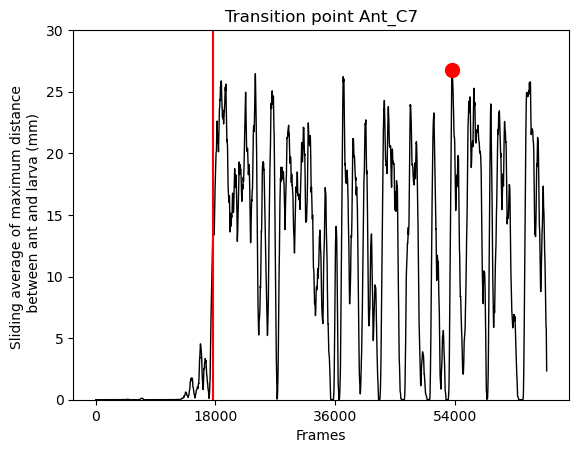

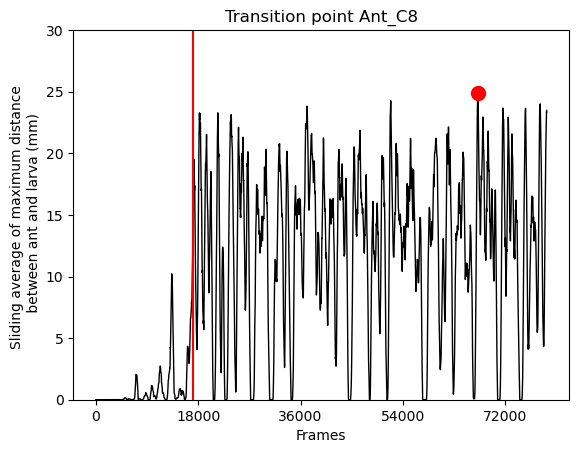

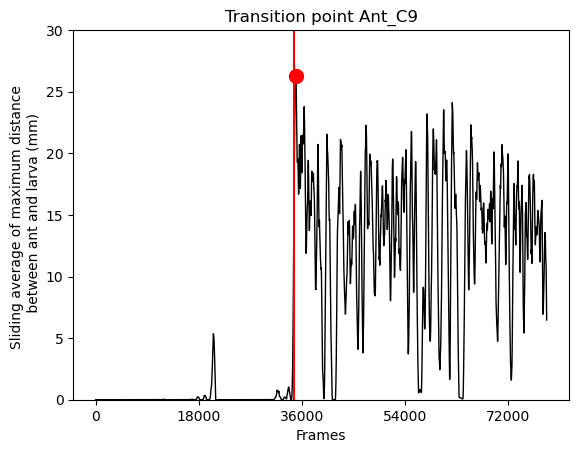

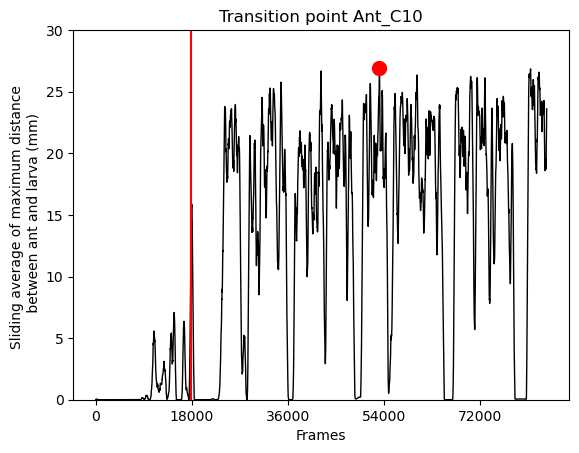

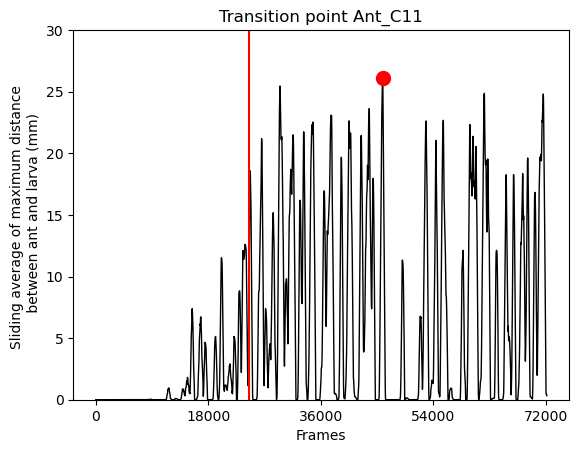

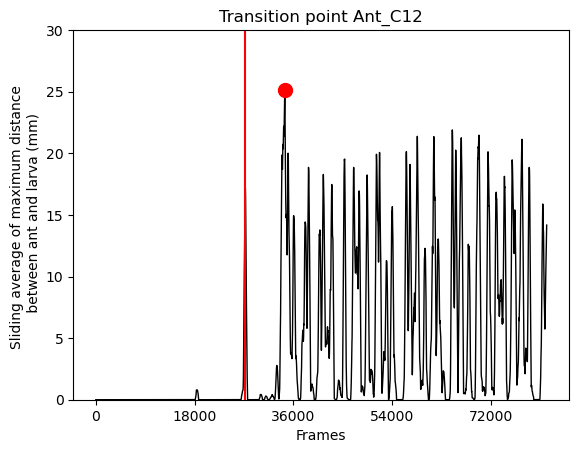

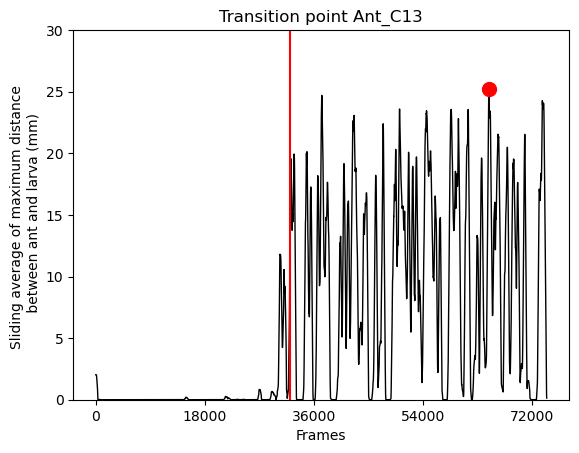

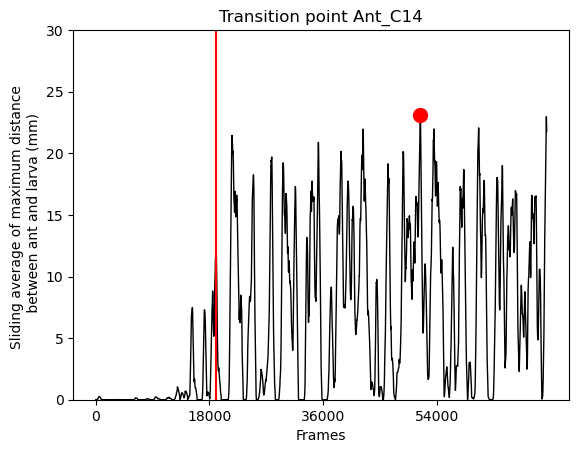

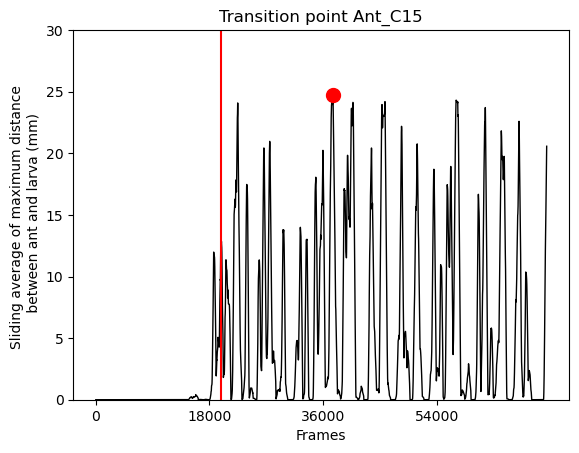

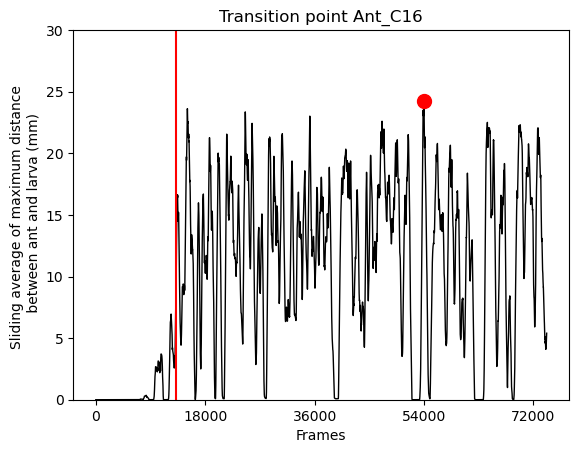

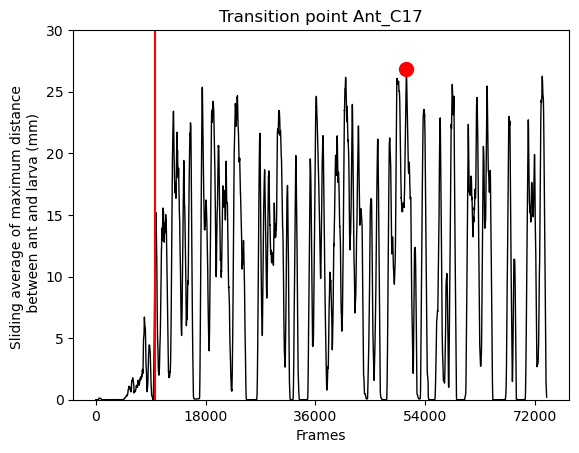

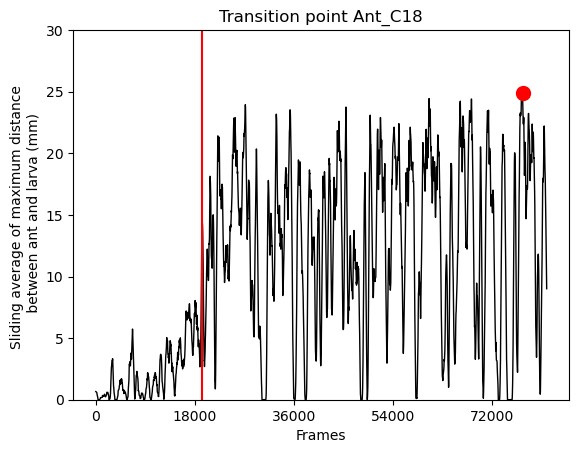

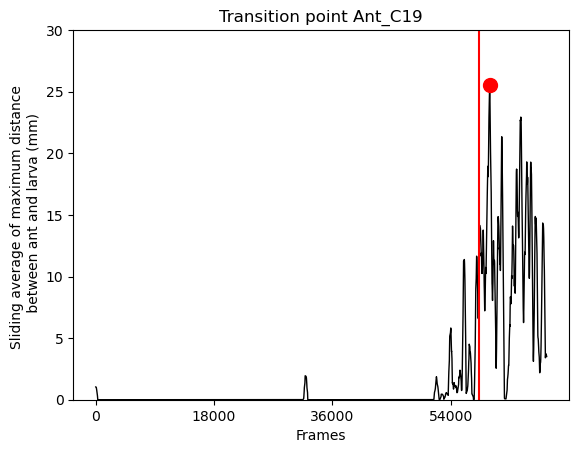

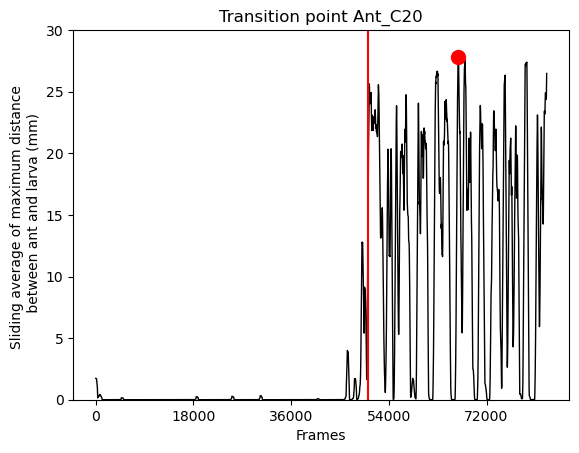

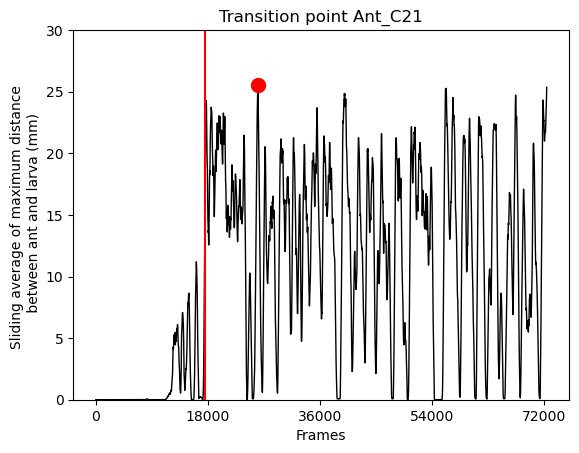

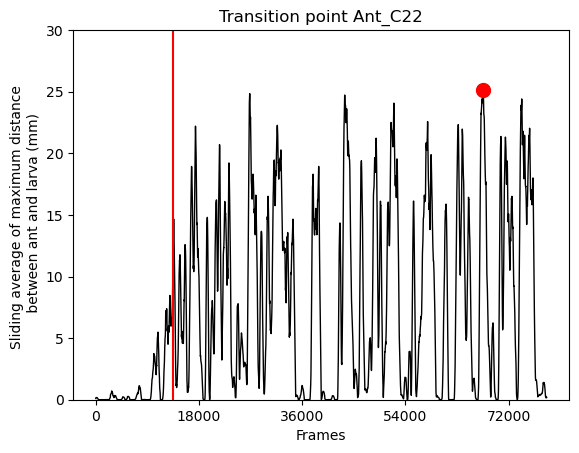

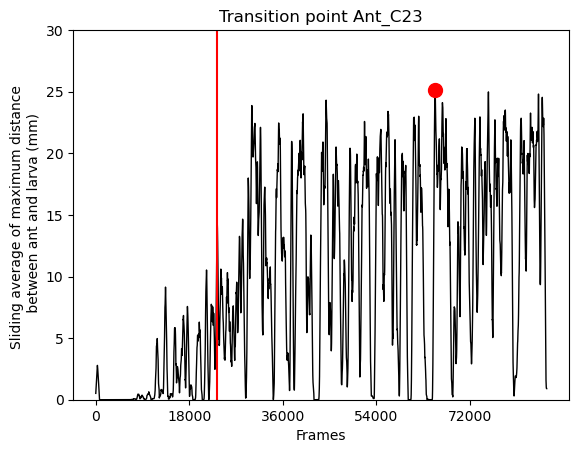

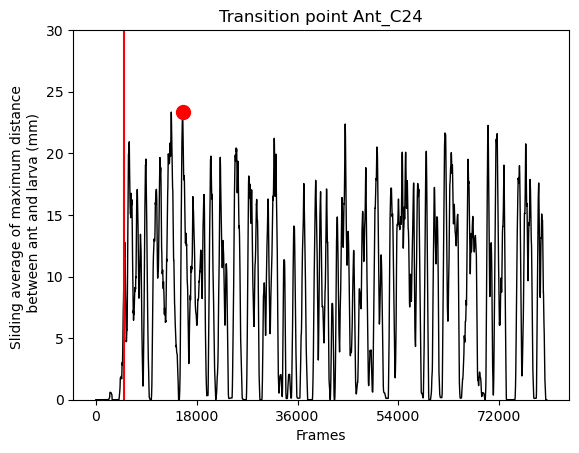

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from natsort import natsorted

#define path to the data files
path = '/Users/Alex/Desktop/Broodcare_assay_Code_&_Sample_data/antrax/analysis/'

#define the save path for the output files
save_path = '/Users/Alex/Desktop/Broodcare_assay_Code_&_Sample_data/antrax/analysis/'

#creates an empty array to store the transition points between phase P1 and P2
transpoints = np.array([])
#creates an empty array to store the Ant id
ant_id = np.array([])

#Load all the data:
#trueLarvaDet contains the frame number of the true larva detection for each ant from the 'stats_corrected.csv' file
trueLarvaDet = np.loadtxt(path + 'stats_corrected.csv', delimiter=',', skiprows=1, usecols = 7)

#creates array of filenames (str) from the given directory, in this case the PositionData_C*.csv files
#glob.glob orders the files in non-natural way, so the natsorted command fixes the ordering 
#such that natural indexing can be used to generate PositionData filenames correctly linked to the PositionData_n.csv's
fnames = glob.glob(path + 'PositionData_C*.csv')
sfnames = natsorted(fnames)

#creates array of filenames (str) from the given directory, in this case the timedata_C*.csv files
#glob.glob orders the files in non-natural way, so the natsorted command fixes the ordering 
#such that natural indexing can be used to generate PositionData filenames correctly linked to the timedata_n.csv's
fnames2 = glob.glob(path + 'timedata_C*.csv')
sfnames2 = natsorted(fnames2)

# The following code is the main loop that determines the transition points between phase P1 and P2, and plots the data.
# We defined the P1 behavioral phase as the period beginning with larva detection and continuing while the ant remains mostly in physical contact with the larva,
# irrespective of whether the ant is carrying the larva around the assay chamber or remaining in one location. Larva carrying did not consistently occur across
# all assays or conditions, and it was therefore collapsed into the P1 phase. The P2 phase was defined as the period when the ant begins to leave the larva
# and subsequently spends most of its time exploring the assay chamber away from the larva. Phase P2 continued until the end of the video recording. 

# To determine the transition points, first, beginning from the frame of true larva detection, we apply a 200 frame (40 second) sliding window over
# the ant’s PositionData in which we calculate the difference between the ant’s absolute minimum and absolute maximum positions.
# We ignore the ant’s PositionData in frames when the ant wass physically interacting with or carrying the larva to only capture PositionData
# from frames when the ant was away from the larva. We save these values as the “AntMaxDistance”. We then smooth the AntMaxDistance data by applying a second,
# 400 frame (80 second) sliding window in which we average the measures. We then calculated the first inflection point of the smoothed AntMaxDistance data
# (i.e., the frame at which the data first exceeds half of the absolute maximum value of the smoothed data) and defined this frame as
# the Transition Point between the P1 and P2 behavioral phases. 


# The code below calculates the AntMaxDistance and Transition Points between P1 and P2 for each ant in the experiment.
# The code also plots the smoothed AntMaxDistance data and the Transition Point for each ant.
i=0
for x in sfnames:
    file = sfnames[i] #current PositionData_C*.csv file
    file2 = sfnames2[i] #current timedata_C*.csv file

    #set the ant_id
    ant_id = np.append(ant_id, 'C'+str(i+1))

    #load data from current files
    A = np.loadtxt(file, delimiter=',', skiprows=1, usecols = (2)) #loads the 'ant-position (mm)' data from the current PositionData_C*.csv file
    interacting = np.loadtxt(file2, delimiter=',', skiprows=1, usecols = (5)) #loads the 'interacting' data from the current timedata_C*.csv file
   
    #Calculte the AntMaxDistance
    #Note, this takes the data staring from the frame of true larva detection
    window=200
    c = np.array([])
    for j in range(int(trueLarvaDet[i]),len(A)-window, 1):
        b = A[j:j+window]
        Amin = np.amin(b)
        Amax = np.amax(b)
        if interacting[j] == 0:
            maxdistance = Amax - Amin
        else:
            maxdistance = (np.absolute(1-np.ma.average(interacting[j:j+window]))) * (Amax - Amin)
        #maxdistance = (Amax - Amin)
        c = np.append(c, maxdistance)
    
    #save the AntMaxDistance data to a csv file.
    np.savetxt(save_path + 'AntMaxDistance_' + str(i+1) + '.csv', c, fmt='%f', delimiter=',',
           header ='Ant max distance')
    
    #smooth the AntMaxDistance data
    f = np.array([])
    for y in range(0, len(c)-window, 1):
        g = np.average(c[y:y+400])
        f = np.append(f, g)
    
    #define the Transistion Point
    # Note the transition point is saved with respect to the frame of true larva detection = 0. To put the transition point in terms of the actual frame number, add the true larva detection frame number to the transition point.
    # The transition point is the first frame where the smoothed AntMaxDistance exceeds half of the maximum value of the smoothed AntMaxDistance.
    halfmax = np.amax(f)/2
    if halfmax == 0:
        halfmaxindex = 0
        transpoints = np.append(transpoints, 0)
    else:
        halfmaxindex = np.argwhere(f>halfmax)
        transpoints = np.append(transpoints, (halfmaxindex[0]))

    #define variable max_x as the index of the maximum value in the array f (smoothed AntMaxDistance)
    max_x = np.argmax(f)
    #define variable max_y as the maximum value in the array f (smoothed AntMaxDistance)
    max_y = np.amax(f)    

    #plot the smoothed AntMaxDistance data and the Transition Point.
    # Note that the plot will show frame 0 as the frame of true larva detection.    
    plt.figure(1)
    plt.title('Transition point Ant_C' + str(i+1))

    plt.plot(f, linewidth=1, color='black')
    
    #plot a single point at max_x, max_y. set the size of the point to 10, and color to red
    plt.plot(max_x, max_y, 'ro', markersize=10)
    if halfmax != 0 :
        plt.vlines(halfmaxindex[0], 0, 30, colors='red')
    plt.ylabel('Sliding average of maximum distance \n between ant and larva (mm)')
    plt.xlabel('Frames')
    plt.ylim(0, 30)
    #set the x axis to be the range of the array f set the step to be 18000 frames
    plt.xticks(np.arange(0, len(f), step=18000))

    plt.savefig(save_path + 'TransitionPoint_C' + str(i+1) + '.pdf')
    plt.show()
    
    i+=1

#put the ant_id and transition points into a dataframe
df = pd.DataFrame({'Ant_id': ant_id, ',Transition_points (in reference to larva_detect = frame 0)': transpoints})

#save the dataframe to a csv file
df.to_csv(save_path + 'TransitionPoints.csv', index=False)